http://localhost:9032/notebooks/Session_5_TorchText_practice/Untitled2.ipynb is exactly the same code with ofcourse the definition of encoer different

In [ ]:
#!wget http://www.manythings.org/anki/deu-eng.zip

In [ ]:
#!unzip deu-eng.zip

## in this cod we are reading teh data from the csv file ..this is important as most of the custom dataset will be in csv format

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.data import Field,TabularDataset,BucketIterator  
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List

import spacy
import numpy as np

import random
import re

import math
import time
import pandas as pd

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
#df = pd.read_csv('deu.txt', sep='\t',header=None)

In [4]:
#df.head()

In [5]:
BATCH_SIZE = 32

In [6]:
def removeURLs(text):
    URLless_string=text
    print(text)
    try:
        
        URLless_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
        print("removed url")
    except:
        print("some error")
    return URLless_string


In [7]:
# # df.columns=['English','German','Notes']
# # subDf=df[['English','German']]

# # subDf.to_csv("deu.csv")
# df = pd.read_csv('data/comments_all.csv')
# df=df[['commentText','commentClassification']]
# df['commentText']=df['commentText'].apply(lambda x:removeURLs(x))
# df['commentClassification']="add "+df['commentClassification']+" end"
# df.to_csv("data/comments_train.csv")

In [8]:
# df.iloc[191]

In [9]:
# df = pd.read_csv('data/comments_train.csv')
# df

#df=df[['commentText','commentClassification']]
#df.to_csv("data/comments_test.csv")

In [10]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz


In [11]:
#spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [12]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [13]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)


In [14]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [15]:
# pd.comments_testAll

In [16]:
fields={'commentText':('SRC',SRC),'commentClassification':('TRG',TRG)}

train_data,test_data=TabularDataset.splits(
                                    path='data',
                                    train='attentionTrain.csv',#this is the traing file
                                    test='attentionTest.csv',##this is the test file
                                    format='csv',
                                    fields=fields)


In [17]:
SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(train_data, min_freq = 1)

In [18]:
vars(test_data.examples[1])['TRG']

['code', 'suggestion']

In [19]:
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)


In [20]:
TRG.vocab.itos[1]

'<pad>'

In [21]:
for i,batch in enumerate(train_iterator):
    print(batch.SRC)
    print(batch.TRG)
    print("i=",i)
    lst=batch.SRC.tolist()
    print(lst)
    for b in lst:
        print("length of file", len(b))
        for j in b:
            print(SRC.vocab.itos[j])
        print("------")
    #print(vars(train_data.examples[i])['TRG'])
    if(i==2):
        break

tensor([[   2,    5,   41,   88,   35,   11,   20,   51,   44,  167,    4,    3,
            1,    1,    1,    1,    1,    1,    1,    1,    1],
        [   2,    5,   14,  243,  362, 2197,  381,   47, 1077,   76,  801,    4,
            3,    1,    1,    1,    1,    1,    1,    1,    1],
        [   2,   22,   17,  546, 2428,    6,    3,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1],
        [   2,   21,  162,  377,    4,    3,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1],
        [   2,   49,   43,    4,  103,   99,    4,    3,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1],
        [   2,   22,  256, 1954,   13, 1061,    6,   11,   39,  784,   14,    3,
            1,    1,    1,    1,    1,    1,    1,    1,    1],
        [   2,  278,   35,    3,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1

In [22]:
vars(train_data.examples[1])['SRC']

['check',
 'for',
 'null',
 'domain',
 'url',
 'add',
 'log',
 'also',
 'if',
 'url',
 'is',
 'null']

In [23]:
### now we will start building the encoder class

class Encoder(nn.Module):
    def __init__(self,
                 input_dim,#length of the vocabulary
                 hid_dim,#512
                 n_layers,#6
                 n_heads,#8
                 pf_dim,#output dimention
                 dropout,
                 device,#cuda
                 max_length=100):
        super().__init__()
        
        self.device=device
        
        #input embedding
        self.tok_embedding=nn.Embedding(input_dim,hid_dim)
        ## convert the indices of the words to the position embedding. since there can be just 
        ## 100 tokens in the sentence hence the embedding will be a matrix of 100*hid_dim
        self.pos_embedding=nn.Embedding(max_length,hid_dim) 
        
        ##create layers ..what happens in each layer is listed
        self.layers=nn.ModuleList([EncoderLayer(hid_dim, ## this is 512
                                                n_heads, ## MHA has n_heads
                                                pf_dim, ## the dimentions of output
                                                dropout,
                                                device
                                                )for _ in range(n_layers)])
        
        
        
        ##define dropout
        self.dropout=nn.Dropout(dropout)
        self.scale=torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    
    ##src=it is a set of input values that are in the form of batch
    ##after the Encoder running will get the inputs for the decoder
    def forward(self,src,src_mask):
        batch_size=src.shape[0]
        src_len=src.shape[1]
        
        ##it will fill the pos vector with the src_len numbers which are repeated batch_size
        ## also for the combination to happen between the pos vector and the input they 
        ## must be of the same dimention
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        ##this is how the batch will look like after combining the scaling factor, positional embedding
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        
        ##pass it to all the layers...these layers is the MHA & feedforward network + residual connections
        ##after the operations also the same variable src is being updated
        for layer in self.layers:
            src = layer(src, src_mask)
            
        return src
        
        
        
        


In [24]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        # the two norm layers
        self.self_attn_layer_norm=nn.LayerNorm(hid_dim)
        self.ff_layer_norm=nn.LayerNorm(hid_dim)
        
        ## MultiHeadAttentionLayer is a class that we will call
        self.self_attention=MultiHeadAttentionLayer(hid_dim,n_heads,dropout,device)
        self.dropout = nn.Dropout(dropout)
        ## the feedforward
        ## PositionwiseFeedforwardLayer is a class that will be called
        self.positionwise_feedforward=PositionwiseFeedforwardLayer(hid_dim,pf_dim,dropout)
        
    ##src is the batch wise data
    def forward(self,src,src_mask):
        
        #src = [batch size, src len, hid dim]...basically each token will be of hid_dim
        ##[[.1,.1,.2,.3,.4,.4,...512 entries]
        ##[.1,.1,.2,.3,.4,.4,...512 entries]] two tokens whose embedding is 512 length and are in the form of a batch
        
        
        #self_attention...it will take the query,key,value matrix and then calculate the self attention. Also to use
        ## the same code for the decoder by passing a src_mask
        #_src,_=self.self_attention(query=src,key=src,value=src,mask=src_mask)
        
        _src,_=self.self_attention(src,src,src,src_mask)
        
        ##apply the dropout, residual and pass to norm
        src=self.self_attn_layer_norm(src+self.dropout(_src))
        
        
        _src=self.positionwise_feedforward(src)
        
        src=self.ff_layer_norm(src+self.dropout(_src))
        
        return src
        

In [25]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
    
        assert hid_dim % n_heads == 0
        
        self.hid_dim=hid_dim
        self.n_heads=n_heads
        self.head_dim=hid_dim // n_heads
        
        ##this is as good as definng a Wq...when ever we will have a linear layer there will be a W associated
        ## also instead of decalring it for the head_dim we are declaring it for the hidden dimention and then 
        ## we will divide the matrix into the n_heads.. this way the code is much general
        self.fc_q=nn.Linear(hid_dim,hid_dim)
        self.fc_k=nn.Linear(hid_dim,hid_dim)
        self.fc_v=nn.Linear(hid_dim,hid_dim)
        
        ## this is the last weight matrix that will be used at the time of concatenation of the outputs        
        self.fc_o=nn.Linear(hid_dim,hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        ##the scaling factor as in scale dot products...this will be the sqrt of the dimention that we are using
        self.scale=torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    
    
    ## there are lot of transformation happeing
    ## [batch,word,hid_dim] -> [batch,word,n_head,head_dim] (view)-> [batch,n_head,word,head_dim] (permute)
    ## ->[batch,words,number_heads,head_dim] (permute +contiguous) -> [batch,words,hid_dim] (view)
    ##
    ##
    def forward(self,query,key,value,mask=None):
        
        #assuming that the matrices have an additional batch dimention
        batch_size = query.shape[0]
        
        #Q=[batch,word,hid_dim]
        Q=self.fc_q(query)
        K=self.fc_k(key)
        V=self.fc_v(value)
        
        #Q is of the dimention [batch,word,hid_dim]
        # we want to create new Q which is [batch,num_head,words,head_dim]
        # it is a 2 step thing...
        # step1 [batch,word,hid_dim] -> [batch,word,n_head,head_dim] using views
        #step2 using permute change the axis from [batch,word,n_head,head_dim] -> [batch,n_head,word,head_dim]
        Q=Q.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
        K=K.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
        V=V.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
        
        
        ## now compuet the energy ..we need to take a transpose of K
        ## this will give us energy dimentions as [batch_len,number_heads,number_words,number_words]
        energy=torch.matmul(Q,K.permute(0,1,3,2))/self.scale
        #0, 1, 3, 2
        ## this is how we will use the mask
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        #attentiox=[batch,number_heads,words,words]
        attention=torch.softmax(energy,dim=-1)
        
        ##this will give x=[batch,number_heads,words,head_dim]
        x=torch.matmul(self.dropout(attention),V)
        
        #batchnumber,words,heads,head_dim..this is some memory optimization operation
        # but the x is also changed from [batch,number_heads,words,head_dim] -> [batch,words,number_heads,head_dim]
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #now number_heads and head_dim are getting combined together to get the single continuous tensor
        #[batch,words,number_heads,head_dim] -> [batch,words,hid_dim]
        x = x.view(batch_size, -1, self.hid_dim)
        
        
        ##pass it through the linear layer
        x=self.fc_o(x)
        
        
        #x=x = [batch size, words, hid dim]
        return x,attention
        
        
        
        
        

In [26]:
##positionwise feed forward layer
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x):
        #x = [batch size, seq len, hid_dim]->[batch size, seq len, pf_dim]    
        x=self.dropout(torch.relu(self.fc_1(x)))
        
        #x=[batch size, seq len, pf_dim]->[batch size, seq len, hid_dim]
        x=self.fc_2(x)
        
        return x
        
    

In [27]:
##decoder
##this should be simialr to the encoder class so I am strating by copying the encoder class
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,#length of the vocabulary
                 hid_dim,#512
                 n_layers,#6
                 n_heads,#8
                 pf_dim,#output dimention
                 dropout,
                 device,#cuda
                 max_length=100):
        super().__init__()
        
        self.device=device
        
        #input embedding
        self.tok_embedding=nn.Embedding(output_dim,hid_dim)
        ## convert the indices of the words to the position embedding. since there can be just 
        ## 100 tokens in the sentence hence the embedding will be a matrix of 100*hid_dim
        self.pos_embedding=nn.Embedding(max_length,hid_dim) 
        
        ##create layers ..what happens in each layer is listed
        self.layers=nn.ModuleList([DecoderLayer(hid_dim, ## this is 512
                                                n_heads, ## MHA has n_heads
                                                pf_dim, ## the dimentions of output
                                                dropout,
                                                device
                                                )
                                    for _ in range(n_layers)])
        
        
        ##thiis is extra
        self.fc_out = nn.Linear(hid_dim, output_dim)
        ##define dropout
        self.dropout=nn.Dropout(dropout)
        self.scale=torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    
    ## the forward function will be little different than the Encoder
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        batch_size=trg.shape[0]
        trg_len=trg.shape[1]
        
        ##it will fill the pos vector with the src_len numbers which are repeated batch_size
        ## also for the combination to happen between the pos vector and the input they 
        ## must be of the same dimention
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        ##this is how the batch will look like after combining the scaling factor, positional embedding
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        
        ##pass it to all the layers...these layers is the MHA & feedforward network + residual connections
        ##after the operations also the same variable src is being updated
        for layer in self.layers:
            trg,attention = layer(trg, enc_src, trg_mask, src_mask)
            
        output=self.fc_out(trg)
        return output,attention
        
        
        
        


In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        #norm for the self attention
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        
        #norm for the encoder _attentions
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        
        #the feedfoward layer normalization..this one is after the encoder-attentions
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        
        ## calculate the self attentions
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        
        # calculate the attention using the K,V coming from encoder
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        
        #feedforward
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
        
        
    def forward(self,trg,enc_src,trg_mask,src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #trg_mask = [batch size, trg len]
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
            
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        
        #encoder attention Q is coming from Decoder while K and V are coming from encoder
        # the src_mask is to stop the decoder from using the <PAD> values in case if any
        #enc_src=[batchsize,source_len,hid_dim]
        #src_mask=[batbatch_size,source_len]
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        _trg=self.positionwise_feedforward(trg)
        
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        return trg,attention
            
            

In [29]:
##this module will encapsulate the encoder -decoder piece . it will also take care of the maskings
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    #this is just to add the 0s at the places which are pad
    def make_src_mask(self, src):        
        #src = [batch size, src len] 
        ## we are chaecking if the word is not a <PAD>..
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]
        return src_mask

    def make_trg_mask(self, trg):
        #first check for the padding and make them 0
        ##this is also checking if the word is not a PAD
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        #if the padding is giving some more locatiosn as 0 then include them as well
        trg_mask = trg_pad_mask & trg_sub_mask
        
        return trg_mask
         
        #src = [batch size, src len]
        #trg = [batch size, trg len]
    def forward(self,src,trg):
            
        #src_mask=[batch size,1,1,src len]
        src_mask = self.make_src_mask(src)

        #trg_mask=[batch size,1,1,trg len]
        trg_mask = self.make_trg_mask(trg)

        #enc_src=[batch size, src len, hid dim]
        enc_src = self.encoder(src, src_mask)

        ##output = [batch size, trg len, output dim]
        #attention = [batch size, n_heads, trg len, src len]  ..in case of the encoder it is bs,nhead,src_len,src_len
        ## but in the case of the decoder Q is coming from decoder(aka target) so trg_len and 
        ## K is coming from encoder so src_len
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        return output,attention

In [30]:


BATCH_SIZE = 32
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]


In [31]:
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
#model

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,652,303 trainable parameters


In [33]:
##weight initialization
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [34]:
model.apply(initialize_weights);


In [35]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [36]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [37]:
# ## this is the code to make sure that all the sentences are propelry formed that is required for the trainign
# from torch.nn.utils.rnn import pad_sequence

# # helper function to club together sequential operations
# def sequential_transforms(*transforms):
#     def func(txt_input):
#         for transform in transforms:
#             txt_input = transform(txt_input)
#         return txt_input
#     return func

# # function to add BOS/EOS and create tensor for input sequence indices
# def tensor_transform(token_ids: List[int]):
#     return torch.cat((torch.tensor([BOS_IDX]), 
#                       torch.tensor(token_ids), 
#                       torch.tensor([EOS_IDX])))

# # src and tgt language text transforms to convert raw strings into tensors indices
# text_transform = {}
# for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
#     text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
#                                                vocab_transform[ln], #Numericalization
#                                                tensor_transform) # Add BOS/EOS and create tensor


# # function to collate data samples into batch tesors
# def collate_fn(batch):
#     src_batch, tgt_batch = [], []
#     for src_sample, tgt_sample in batch:
#         src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
#         tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

#     src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
#     tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
#     return src_batch, tgt_batch

In [38]:
from torch.utils.data import DataLoader

# def train_epoch(model, optimizer):
#     model.train()
#     losses = 0
# #     train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
# #     train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
#     #for src, tgt in train_dataloader:
#     count=0
#     for i,batch in enumerate(train_iterator):
#         src = batch.SRC.to(device)
#         tgt = batch.TRG.to(device)
#         # print(src.shape)
#         # print(tgt.shape)
#         # print(tgt[:,:-1].shape)

#         optimizer.zero_grad()
#         ##some issue here...need to check
#         output, _ = model(src, tgt[:,:-1])

#         output_dim = output.shape[-1]
            
#         output = output.contiguous().view(-1, output_dim)
#         tgt = tgt[:,1:].contiguous().view(-1)

#         # output = output[1:].view(-1, output.shape[-1])
#         # tgt = tgt[1:].reshape(-1) #tgt[:,:-1][1:].reshape(-1)
#         loss = loss_fn(output, tgt)
#         loss.backward()
#         clip = 1
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

#         optimizer.step()
#         losses += loss.item()
#         count+=1

#     return losses / count
def train_epoch(model, optimizer):
    model.train()
    losses = 0
#     train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
#     train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    #for src, tgt in train_dataloader:
    count=0
    for i,batch in enumerate(train_iterator):
        try:
            src = batch.SRC.to(device)
            tgt = batch.TRG.to(device)
            # print(src.shape)
#             print(tgt.shape)
#             print(tgt[:,:-1].shape)
#             print(i)

#             print(batch.SRC)
#             print(batch.TRG)
#             print("i=",i)
#             lst=batch.SRC.tolist()
#             print(lst)
#             for b in lst:
#                 print("length of file", len(b))
#                 for j in b:
#                     print(SRC.vocab.itos[j])
#                 print("------")

            optimizer.zero_grad()
            output, _ = model(src, tgt[:,:-1]) #[:,:-1])

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            tgt = tgt[:,1:].contiguous().view(-1)

            # output = output[1:].view(-1, output.shape[-1])
            # tgt = tgt[1:].reshape(-1) #tgt[:,:-1][1:].reshape(-1)
            loss = loss_fn(output, tgt)
            loss.backward()
            clip = 1
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
            losses += loss.item()
            count+=1
        except:
            print("error found at ",i)
                        # print(src.shape)
#             print(tgt.shape)
#             print(tgt[:,:-1].shape)
#             print(i)

#             print(batch.SRC)
#             print(batch.TRG)
#             print("i=",i)
#             lst=batch.SRC.tolist()
#             print(lst)
#             for b in lst:
#                 print("length of file", len(b))
#                 for j in b:
#                     print(SRC.vocab.itos[j])
#                 print("------")

            
            
            
            

    return losses / count


In [39]:
def evaluate(model):
    model.eval()
    losses = 0

#     val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
#     val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    count=0
    for i,batch in enumerate(train_iterator):
        src = batch.SRC.to(device)
        tgt = batch.TRG.to(device)[:,:-1]
        
        output, _ = model(src, tgt[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:,1:].contiguous().view(-1)

        # output = output[1:].view(-1, output.shape[-1])
        # tgt = tgt[1:].reshape(-1)
        loss = loss_fn(output, tgt)
        losses += loss.item()
        count+=1
    return losses / count


In [40]:
from timeit import default_timer as timer
NUM_EPOCHS = 100
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    end_time = timer()
    val_loss = evaluate(model)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f},Val loss: {val_loss:.3f} Train PPL: {math.exp(train_loss):7.3f}  "f"Epoch time = {(end_time - start_time):.3f}s"))
    train_losses.append(train_loss)
    val_losses.append(val_loss)


Epoch: 1, Train loss: 0.765,Val loss: 0.530 Train PPL:   2.148  Epoch time = 7.023s
Epoch: 2, Train loss: 0.317,Val loss: 0.261 Train PPL:   1.373  Epoch time = 7.863s
Epoch: 3, Train loss: 0.203,Val loss: 0.194 Train PPL:   1.225  Epoch time = 7.125s
Epoch: 4, Train loss: 0.136,Val loss: 0.099 Train PPL:   1.146  Epoch time = 6.958s
Epoch: 5, Train loss: 0.092,Val loss: 0.057 Train PPL:   1.096  Epoch time = 7.878s
Epoch: 6, Train loss: 0.069,Val loss: 0.072 Train PPL:   1.071  Epoch time = 7.286s
Epoch: 7, Train loss: 0.052,Val loss: 0.038 Train PPL:   1.053  Epoch time = 7.375s
Epoch: 8, Train loss: 0.048,Val loss: 0.047 Train PPL:   1.050  Epoch time = 7.911s
Epoch: 9, Train loss: 0.038,Val loss: 0.021 Train PPL:   1.038  Epoch time = 7.148s
Epoch: 10, Train loss: 0.039,Val loss: 0.019 Train PPL:   1.040  Epoch time = 7.627s
Epoch: 11, Train loss: 0.026,Val loss: 0.034 Train PPL:   1.026  Epoch time = 7.885s
Epoch: 12, Train loss: 0.028,Val loss: 0.015 Train PPL:   1.029  Epoch tim

Epoch: 98, Train loss: 0.015,Val loss: 0.010 Train PPL:   1.015  Epoch time = 9.010s
Epoch: 99, Train loss: 0.021,Val loss: 0.007 Train PPL:   1.021  Epoch time = 8.384s
Epoch: 100, Train loss: 0.015,Val loss: 0.008 Train PPL:   1.015  Epoch time = 8.919s


In [87]:
train_losses

[0.019490875619552792,
 0.020752492833301578,
 0.015918305809077053,
 0.013010261928394221,
 0.008659975513279626,
 0.013147805170484254,
 0.010607275094948722,
 0.012777534914927488,
 0.01267196880925962,
 0.01359922630589163,
 0.018356752405104107,
 0.011778397275539898,
 0.014258318769552329,
 0.01416218710917437,
 0.028394433888334267,
 0.019155865299522856,
 0.016868898217000335,
 0.1166336673585589,
 0.05484068961231969,
 0.017231686754422163,
 0.01718949526532905,
 0.014749374000530224,
 0.016068015724390823,
 0.012019557247147029,
 0.00817884084136359,
 0.013355585250811852,
 0.017860552735386438,
 0.015933393931033046,
 0.020067394310744738,
 0.009666671733089544,
 0.01734452664405058,
 0.019286131571595647,
 0.008508756438962511,
 0.01531101446287605,
 0.01636688795607621,
 0.017904658697203712,
 0.016383062876984503,
 0.01194023420217452,
 0.018909380248202223,
 0.011150494424482725,
 0.014875521887122576,
 0.010550435761576816,
 0.004598363881241505,
 0.016354323129409286,


In [47]:
df_stats=pd.DataFrame(list(train_losses))
df_stats['val_losses']=list(val_losses)
df_stats.columns=['train_loss','val_loss']
df_stats

,train_loss,val_loss
0,0.764539,0.530184
1,0.316991,0.260702
2,0.203184,0.194429
3,0.136467,0.098934
4,0.091537,0.057138
...,...,...
95,0.005143,0.014807
96,0.012788,0.009267
97,0.015355,0.010281
98,0.020936,0.007396


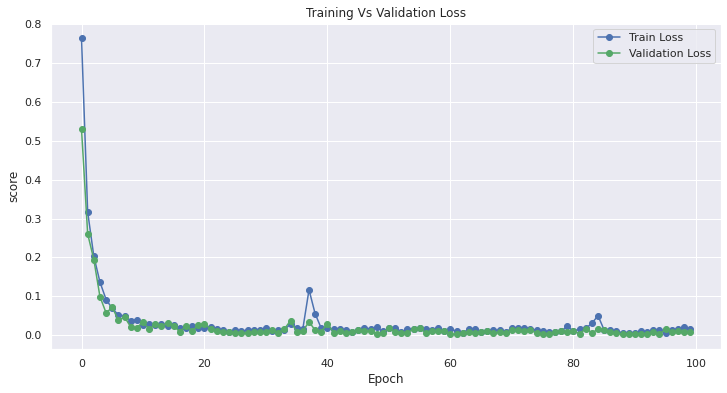

In [54]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

import seaborn as sns
from  matplotlib.ticker import FuncFormatter
# Use plot styling from seaborn.
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (12,6)
# Plot the learning curve.
plt.plot(df_stats['train_loss'], 'b-o', label="Train Loss")
plt.plot(df_stats['val_loss'], 'g-o', label="Validation Loss")
#plt.plot(df_stats['PPL'], 'r-o', label="Perplexity")
#plt.plot(df_stats['BERTSCORE'], 'c-o', label="Bert Score")
#plt.plot(df_stats[plotTypeVar[i]], colorArr[i], label=labelsArr[i])
# Label the plot.
plt.title("Training Vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("score")
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: (int(x))))
plt.show()

In [ ]:
Epoch: 1, Train loss: 4.027, Train PPL:  56.102 | Val loss: 3.030, Val. PPL:  20.690 | Epoch time = 21.458s
Epoch: 2, Train loss: 2.643, Train PPL:  14.049 | Val loss: 2.407, Val. PPL:  11.095 | Epoch time = 21.550s
Epoch: 3, Train loss: 2.072, Train PPL:   7.944 | Val loss: 2.182, Val. PPL:   8.864 | Epoch time = 21.634s
Epoch: 4, Train loss: 1.703, Train PPL:   5.492 | Val loss: 2.080, Val. PPL:   8.002 | Epoch time = 21.682s
Epoch: 5, Train loss: 1.435, Train PPL:   4.199 | Val loss: 2.045, Val. PPL:   7.730 | Epoch time = 21.998s
Epoch: 6, Train loss: 1.225, Train PPL:   3.403 | Val loss: 2.045, Val. PPL:   7.727 | Epoch time = 22.008s
Epoch: 7, Train loss: 1.049, Train PPL:   2.854 | Val loss: 2.051, Val. PPL:   7.777 | Epoch time = 22.021s
Epoch: 8, Train loss: 0.905, Train PPL:   2.472 | Val loss: 2.121, Val. PPL:   8.342 | Epoch time = 21.982s
Epoch: 9, Train loss: 0.792, Train PPL:   2.209 | Val loss: 2.179, Val. PPL:   8.834 | Epoch time = 22.050s
Epoch: 10, Train loss: 0.700, Train PPL:   2.014 | Val loss: 2.217, Val. PPL:   9.178 | Epoch time = 22.096s

In [41]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
#     if isinstance(sentence, str):
#         src_tensor = text_transform[SRC_LANGUAGE](sentence).unsqueeze(0).to(device)
#     else:
#         src_tensor = text_transform[TGT_LANGUAGE](sentence).unsqueeze(0).to(device)
    
#     src_mask = model.make_src_mask(src_tensor)
    
    
    if isinstance(sentence, str):
        nlp = spacy.load('en_core_web_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    #trg_indexes = [trg_field[init_token]]
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]


    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        #if pred_token == trg_field[eos_token]:
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
            
    
    #trg_tokens = [trg_field.vocab.get_itos()[i] for i in trg_indexes]
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [42]:
for example_idx in range(20,30):

    src = vars(test_data.examples[example_idx])['SRC']
    trg = vars(test_data.examples[example_idx])['TRG']

    print("src = ",' '.join(src))
    print("trg =" ,' '.join(trg))

    translation, attention = translate_sentence(src, SRC, TRG, model, device)
    print("predicted trg =" ,' '.join(translation))
    print("*"*40)
    #print(f'predicted trg = {' '.join(translation)}')

src =  can we create a constant for week month then iterate it ?
trg = buggycode suggestion
predicted trg = refactoring suggestion <eos>
****************************************
src =  please get it verified and update the pr once verified .
trg = completeness suggestion
predicted trg = completeness suggestion <eos>
****************************************
src =  its a default part of the gst gst cgst sgst igst cess advalorem state cess
trg = logical suggestion
predicted trg = logistics suggestion <eos>
****************************************
src =  please use isrequired feature of the formdefinitions .
trg = reuse suggestion
predicted trg = logical suggestion <eos>
****************************************
src =    atomicreference any specific region to use this here ?
trg = code suggestion
predicted trg = questioning <eos>
****************************************
src =  can we extract this to a common place ? is there a chance for any other modules to use it ?
trg = refactoring sugge

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [45]:
translation, attention = translate_sentence("nope we will harcode color like this", SRC, TRG, model, device)
print("predicted trg =" ,' '.join(translation))
print("*"*40)

predicted trg = buggycode suggestion <eos>
****************************************
